Part 1. Spectrum counting analysis  
1a. highest rounded average count is 215 and 100th rounded average count is 3  
1b. KO1    217.0  
KO2    217.0  
KO3    202.0  
KO4    217.0  
KO5    217.0  
WT1    193.0  
WT2    160.0  
WT3    176.0  
WT4    164.0  
WT5    176.0    
  
2a. see below    
2b. Number of peptides with p < 0.05: 234  

3a. Number of peptides passing Bonferroni correction: 44  
Number of peptides passing Benjamini-Hochberg correction: 88  
3b. see below for graph, FDR changes the p value because the p values are adjusted to account or false discovery rate 

In [4]:
import pandas as pd

# Load the dataset to inspect its structure
data_path = r"C:\Users\chenm\Downloads\spectrum_count.csv"
data = pd.read_csv(data_path)

# Sort each column 
sorted_data = data.iloc[:, 1:].apply(lambda x: x.sort_values(ignore_index=True))

# Calculate the rounded average for each quantile across columns
quantile_averages = sorted_data.mean(axis=1).round()

highest_rounded_average_count = quantile_averages.max()
rounded_average_100th = quantile_averages.iloc[99]

highest_rounded_average_count, rounded_average_100th



(215.0, 3.0)

In [5]:
min_value = data.min().min()
data_filled = data.fillna(min_value)

# Sort each column independently and compute quantile averages
sorted_data = data_filled.apply(lambda x: x.sort_values().reset_index(drop=True), axis=0)
quantile_averages = sorted_data.mean(axis=1).round()

# Apply quantile averages back to the original data structure, maintaining original indexing
adjusted_data = data.apply(lambda x: x.rank(method='first').astype(int) - 1)
adjusted_data = adjusted_data.apply(lambda x: quantile_averages[x].values)

# Assuming the first row corresponds to 'Protein_1'
protein_1_adjusted_counts = adjusted_data.iloc[0]

protein_1_adjusted_counts



KO1    217.0
KO2    217.0
KO3    202.0
KO4    217.0
KO5    217.0
WT1    193.0
WT2    160.0
WT3    176.0
WT4    164.0
WT5    176.0
Name: 0, dtype: float64

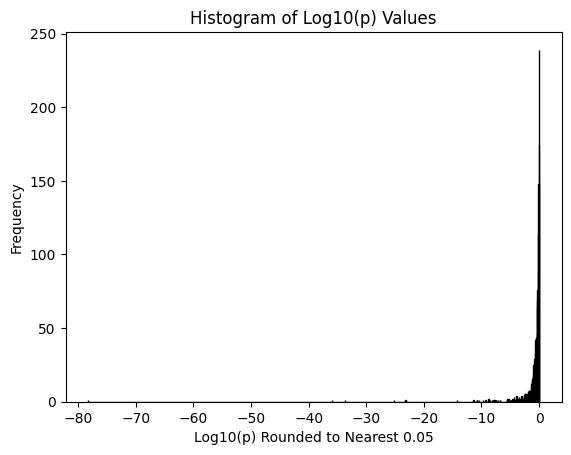

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
# Summing the KO columns (KO1 to KO5)
adjusted_data['KO'] = adjusted_data[['KO1', 'KO2', 'KO3', 'KO4', 'KO5']].sum(axis=1)

# Summing the WT columns (WT1 to WT5)
adjusted_data['WT'] = adjusted_data[['WT1', 'WT2', 'WT3', 'WT4', 'WT5']].sum(axis=1)
def calculate_log10_p(ko, wt):
    # Fisher's exact test requires a 2x2 contingency table.
    # We assume the background or expected count is the sum of all KO and WT minus the count for this protein
    total_ko = adjusted_data['KO'].sum()
    total_wt = adjusted_data['WT'].sum()
    n_ko = ko
    n_wt = wt
    n_ko_bg = total_ko - ko
    n_wt_bg = total_wt - wt

    # Create a contingency table
    table = [[n_ko, n_wt], [n_ko_bg, n_wt_bg]]

    # Calculate Fisher's exact test p-value
    _, p_value = fisher_exact(table, 'greater')  # Use 'greater' for one-sided test as needed

    # Calculate log10(p)
    return np.log10(p_value) if p_value > 0 else -np.inf  # Avoid log10(0)

# Apply function to each row in DataFrame
adjusted_data['log10_p'] = adjusted_data.apply(lambda row: calculate_log10_p(row['KO'], row['WT']), axis=1)

# Filter out infinite values which result from log10(0) which could occur if p_value is exactly 0
log10_p_values = adjusted_data['log10_p'].replace(-np.inf, np.nan).dropna()

# Round values to nearest 0.05 for binning
log10_p_values_rounded = np.round(log10_p_values / 0.05) * 0.05

# Plot histogram
plt.hist(log10_p_values_rounded, bins=np.arange(min(log10_p_values_rounded), max(log10_p_values_rounded) + 0.05, 0.05), edgecolor='black')
plt.xlabel('Log10(p) Rounded to Nearest 0.05')
plt.ylabel('Frequency')
plt.title('Histogram of Log10(p) Values')
plt.show()



In [21]:
# Convert log10(p) back to p-values
adjusted_data['p_value'] = 10 ** adjusted_data['log10_p']

# Count peptides with p < 0.05
num_peptides_below_threshold = (adjusted_data['p_value'] < 0.05).sum()

print(f"Number of peptides with p < 0.05: {num_peptides_below_threshold}")



Number of peptides with p < 0.05: 234


In [22]:
# Number of tests
num_tests = adjusted_data.shape[0]

# Bonferroni corrected threshold
bonferroni_threshold = 0.05 / num_tests

# Counting peptides that pass the Bonferroni threshold
num_peptides_bonferroni = (adjusted_data['p_value'] < bonferroni_threshold).sum()

print(f"Number of peptides passing Bonferroni correction: {num_peptides_bonferroni}")

# Convert log10(p) back to p-values if not already done
adjusted_data['p_value'] = 10 ** adjusted_data['log10_p']

# Sorting p-values in ascending order
adjusted_data_sorted = adjusted_data.sort_values(by='p_value')
adjusted_data_sorted['rank'] = range(1, len(adjusted_data_sorted) + 1)  # Rank of the p-values

# Calculate the critical values for BH correction (i / m * alpha, where i is the rank, m is total tests, alpha is 0.05)
adjusted_data_sorted['critical_value'] = (adjusted_data_sorted['rank'] / num_tests) * 0.05

# Find the largest rank where p-value is less than the critical value
max_rank = adjusted_data_sorted[adjusted_data_sorted['p_value'] <= adjusted_data_sorted['critical_value']]['rank'].max()

# Count the number of peptides that pass the BH threshold
num_peptides_bh = (adjusted_data_sorted['rank'] <= max_rank).sum() if not np.isnan(max_rank) else 0

print(f"Number of peptides passing Benjamini-Hochberg correction: {num_peptides_bh}")



Number of peptides passing Bonferroni correction: 44
Number of peptides passing Benjamini-Hochberg correction: 88


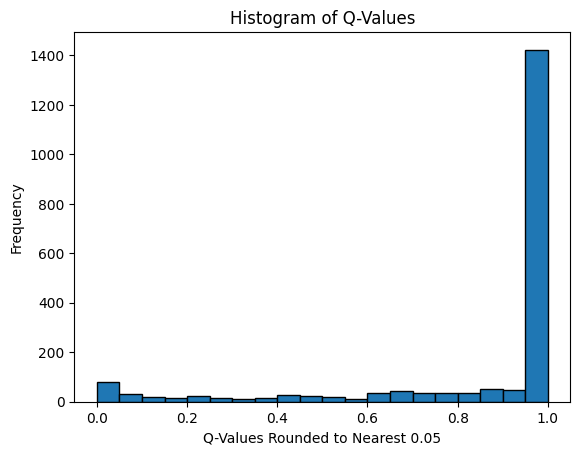

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data and prepare it
# adjusted_data should already have p-values computed and added in a 'p_value' column

# Sort p-values in ascending order
adjusted_data_sorted = adjusted_data.sort_values(by='p_value')
adjusted_data_sorted['rank'] = range(1, len(adjusted_data_sorted) + 1)  # Rank the p-values

# Calculate q-values
adjusted_data_sorted['q_value'] = adjusted_data_sorted['p_value'] * (len(adjusted_data_sorted) / adjusted_data_sorted['rank'])

# Now let's adjust these q-values to be non-decreasing
adjusted_data_sorted['q_value'] = adjusted_data_sorted['q_value'][::-1].cummin()[::-1]

# Round q-values to the nearest 0.05 for binning
adjusted_data_sorted['q_value_rounded'] = np.round(adjusted_data_sorted['q_value'] / 0.05) * 0.05

# Plot histogram of the q-values
plt.hist(adjusted_data_sorted['q_value_rounded'], bins=np.arange(0, adjusted_data_sorted['q_value_rounded'].max() + 0.05, 0.05), edgecolor='black')
plt.xlabel('Q-Values Rounded to Nearest 0.05')
plt.ylabel('Frequency')
plt.title('Histogram of Q-Values')
plt.show()



Part 3: the ascore algorithm  
1a. b-type ions:  

b1: S  
b2: SLp  
b3: SLEp  
b4: SLEPpS  
b5: SLEPpSG  
b6: SLEPpSGI  
b7: SLEPpSGIL  
b8: SLEPpSGILL  
b9: SLEPpSGILLK  
y-type ions:  

y1: K  
y2: LK  
y3: ILK  
y4: GILK  
y5: SGILK  
y6: PSGILK  
y7: EPSGILK  
y8: LEPSGILK  
y9: SLEPSGILK  

1b. b-type ions:
('b1', 'S', 87.03)
('b2', 'SL', 280.17)
('b3', 'SLE', 409.29)
('b4', 'SLEP', 506.41)
('b5', 'SLEPS', 593.44)
('b6', 'SLEPSG', 650.46)
('b7', 'SLEPSGI', 763.62)
('b8', 'SLEPSGIL', 876.78)
('b9', 'SLEPSGILL', 989.94)

y-type ions:
('y1', 'K', 208.16)
('y2', 'LK', 321.32)
('y3', 'LLK', 434.48)
('y4', 'ILLK', 547.64)
('y5', 'GILLK', 604.66)
('y6', 'SGILLK', 691.69)
('y7', 'PSGILLK', 788.81)
('y8', 'EPSGILLK', 917.93)
('y9', 'LEPSGILLK', 951.11)  

2a. Matched b-type ions: 2  
Matched y-type ions: 6  
Total distinguishing ions (n): 8  
Matched b-type ions details:  
281.177276 matched.  
410.297276 matched.  
Matched y-type ions details:  
129.17727599999998 matched.  
242.337276 matched.  
355.497276 matched.  
468.65727599999997 matched.  
709.8272760000001 matched.  
838.9472760000001 matched.   

3a. Probability of best isomer (P1): 9.154956960000008e-12  
Probability of second best isomer (P2): 6.442043387911565e-06  
Ascore: -58.47367338614062  
3b. New Probability of best isomer (P1): 0.0147857666015625  
New Probability of second best isomer (P2): 0.17619705200195312  
New Ascore: -10.76154791417437, the score does improve/ increase  
3c. p would increase proportionally if tolerance is reduced and score would increase due to p 



In [10]:
# Define the amino acid masses (monoisotopic)
amino_acid_masses = {
    'S': 87.03,  # Including common mass of Serine
    'L': 113.16,
    'E': 129.12,
    'P': 97.12,
    'G': 57.02,
    'I': 113.16,
    'K': 128.18
}

# Phosphorylation mass increase
phosphorylation_mass = 79.98

# Calculate the mass of a peptide sequence
def calculate_mass(sequence):
    mass = 0.0
    for aa in sequence:
        mass += amino_acid_masses.get(aa, 0)
    return mass

# Generate b- and y-type ions for a phosphopeptide with phosphorylation at a given position (1-based index)
def generate_ions(sequence, phospho_position):
    b_ions = []
    y_ions = []
    
    # Generate b- and y-type ions
    for i in range(1, len(sequence)):
        b_seq = sequence[:i]
        y_seq = sequence[-i:]
        
        # Add phosphorylation mass if within the phospho position
        b_mass = calculate_mass(b_seq)
        y_mass = calculate_mass(y_seq)
        
        if i >= phospho_position:
            b_mass += phosphorylation_mass
        
        if len(sequence) - i >= phospho_position:
            y_mass += phosphorylation_mass
        
        b_ions.append((f"b{i}", b_seq, round(b_mass, 2)))
        y_ions.append((f"y{i}", y_seq, round(y_mass, 2)))
    
    return b_ions, y_ions

# Example usage
sequence = 'SLEPSGILLK'
phospho_position = 2  # Assuming phosphorylation is on the second residue (S)

b_ions, y_ions = generate_ions(sequence, phospho_position)

# Output the ions and their masses
print("b-type ions:")
for ion in b_ions:
    print(ion)

print("\ny-type ions:")
for ion in y_ions:
    print(ion)


b-type ions:
('b1', 'S', 87.03)
('b2', 'SL', 280.17)
('b3', 'SLE', 409.29)
('b4', 'SLEP', 506.41)
('b5', 'SLEPS', 593.44)
('b6', 'SLEPSG', 650.46)
('b7', 'SLEPSGI', 763.62)
('b8', 'SLEPSGIL', 876.78)
('b9', 'SLEPSGILL', 989.94)

y-type ions:
('y1', 'K', 208.16)
('y2', 'LK', 321.32)
('y3', 'LLK', 434.48)
('y4', 'ILLK', 547.64)
('y5', 'GILLK', 604.66)
('y6', 'SGILLK', 691.69)
('y7', 'PSGILLK', 788.81)
('y8', 'EPSGILLK', 917.93)
('y9', 'LEPSGILLK', 951.11)


In [17]:
import numpy as np

# Define theoretical ions masses for b-type and y-type
b_ions_masses = [280.17, 409.29, 506.41, 593.44, 650.46, 763.62, 876.78, 989.94]
y_ions_masses = [128.17, 241.33, 354.49, 467.65, 524.67, 611.70, 708.82, 837.94, 951.11]

# Add a proton mass to each theoretical ion mass to account for the charge state
proton_mass = 1.007276
b_ions_masses = [mass + proton_mass for mass in b_ions_masses]
y_ions_masses = [mass + proton_mass for mass in y_ions_masses]

# Experimental m/z values
experimental_mz = [
    120.08, 126.09, 129.10, 130.07, 130.09, 136.08, 147.11, 155.12, 173.13,
    175.12, 183.11, 185.09, 201.12, 238.15, 242.11, 249.12, 253.09, 260.20,
    266.15, 281.09, 284.16, 294.14, 303.18, 312.15, 313.16, 327.20, 355.20,
    356.20, 364.24, 364.74, 373.28, 410.13, 438.23, 440.29, 454.26, 454.77,
    466.23, 468.28, 469.28, 486.36, 519.81, 520.31, 543.38, 553.37, 569.32,
    581.36, 582.37, 614.33, 630.42, 631.42, 709.46, 727.47, 728.35, 728.47,
    729.47, 774.41, 838.50, 839.50, 856.51, 857.51, 858.51
]

# Match theoretical ions with experimental values within a tolerance of ±0.5
mass_tolerance = 0.5
matches_b = {ion: any(np.isclose(ion, exp_mz, atol=mass_tolerance) for exp_mz in experimental_mz) for ion in b_ions_masses}
matches_y = {ion: any(np.isclose(ion, exp_mz, atol=mass_tolerance) for exp_mz in experimental_mz) for ion in y_ions_masses}

# Count the matches
matched_b = sum(matches_b.values())
matched_y = sum(matches_y.values())

# Print the matches
print("Matched b-type ions:", matched_b)
print("Matched y-type ions:", matched_y)
print("Total distinguishing ions (n):", matched_b + matched_y)

# Display which ions matched for further investigation
print("Matched b-type ions details:")
for ion, matched in matches_b.items():
    if matched:
        print(f"{ion} matched.")

print("Matched y-type ions details:")
for ion, matched in matches_y.items():
    if matched:
        print(f"{ion} matched.")



Matched b-type ions: 2
Matched y-type ions: 6
Total distinguishing ions (n): 8
Matched b-type ions details:
281.177276 matched.
410.297276 matched.
Matched y-type ions details:
129.17727599999998 matched.
242.337276 matched.
355.497276 matched.
468.65727599999997 matched.
709.8272760000001 matched.
838.9472760000001 matched.


In [24]:
from scipy.special import comb
from scipy.stats import binom
import numpy as np

# Given values
N = 20  # Let's assume there are 20 possible matching ions
n1 = 15  # Number of matches for best isomer
n2 = 10  # Number of matches for second best isomer
p = 0.1  # Prior probability of a correct match

# Calculate probabilities using the binomial distribution formula
P1 = comb(N, n1) * (p**n1) * ((1-p)**(N-n1))
P2 = comb(N, n2) * (p**n2) * ((1-p)**(N-n2))

# Calculate Ascore
Ascore = 10 * np.log10(P1 / P2)

print(f"Probability of best isomer (P1): {P1}")
print(f"Probability of second best isomer (P2): {P2}")
print(f"Ascore: {Ascore}")


Probability of best isomer (P1): 9.154956960000008e-12
Probability of second best isomer (P2): 6.442043387911565e-06
Ascore: -58.47367338614062


In [25]:
from scipy.special import comb
from scipy.stats import binom
import numpy as np

# Revised values
N = 20  # Total possible matching ions remains (adjust based on your actual theoretical spectrum calculations)
n1 = 15  # Number of matches for best isomer remains
n2 = 10  # Number of matches for second best isomer remains
p_new = 0.5  # New prior probability given peak depth=1 and reduced noise

# Calculate probabilities using the binomial distribution formula
P1_new = comb(N, n1) * (p_new**n1) * ((1-p_new)**(N-n1))
P2_new = comb(N, n2) * (p_new**n2) * ((1-p_new)**(N-n2))

# Calculate Ascore
Ascore_new = 10 * np.log10(P1_new / P2_new)

print(f"New Probability of best isomer (P1): {P1_new}")
print(f"New Probability of second best isomer (P2): {P2_new}")
print(f"New Ascore: {Ascore_new}")



New Probability of best isomer (P1): 0.0147857666015625
New Probability of second best isomer (P2): 0.17619705200195312
New Ascore: -10.76154791417437


In [26]:
from scipy.special import comb
import numpy as np

# Re-estimate the probabilities with new p
N = 20  # Total ions possible
n1 = 15  # Best match count
n2 = 10  # Second-best match count
p_new = 0.2  # Adjusted prior probability with tighter mass accuracy

P1_new = comb(N, n1) * (p_new**n1) * ((1-p_new)**(N-n1))
P2_new = comb(N, n2) * (p_new**n2) * ((1-p_new)**(N-n2))
Ascore_new = 10 * np.log10(P1_new / P2_new)

print(f"Adjusted Probability of best isomer (P1) with new p: {P1_new}")
print(f"Adjusted Probability of second best isomer (P2) with new p: {P2_new}")
print(f"Adjusted Ascore with new p: {Ascore_new}")


Adjusted Probability of best isomer (P1) with new p: 1.6647293239296019e-07
Adjusted Probability of second best isomer (P2) with new p: 0.0020314137030138287
Adjusted Ascore with new p: -40.86454748057249
